In [4]:
from All_functions_simulation_univariate import * 
from sklearn.linear_model import QuantileRegressor
# my_plot(X_t,Y_t,M_t,V_t,ylim,legend_loc='upper right')

In [5]:
################################### Data Generating ###################################

def myData(i, n=2000):
    """
    i: random seed
    n: number of samples
    """
    np.random.seed(i)
    X = np.random.uniform(-1, 1, n).reshape(-1, 1)
    Y = np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)
    
    return X, Y

In [ ]:
################################### Different Methods ###################################

def UTOPIA(X,Y,alpha = 0.05,n_train=1000,n_t = 1000,known_mean = "False"):
    """
    X,Y: input data
    alpha: coverage level
    """
    X_pre = X[0:n_train,:].reshape(-1, 1)
    Y_pre = Y[0:n_train,:].reshape(-1, 1)

    X_opt = X[0:n_train,:].reshape(-1, 1)
    Y_opt = Y[0:n_train,:].reshape(-1, 1)

    X_adj = X[0:n_train,:].reshape(-1, 1)
    Y_adj = Y[0:n_train,:].reshape(-1, 1)


    X_t = X[n_train:,:].reshape(-1, 1)
    Y_t = Y[n_train:,:].reshape(-1, 1)
    
    # Obtain mean estimator
    if known_mean == "True":
        M_pre = np.zeros(n_train).reshape(-1,1)
        M_opt = np.zeros(n_train).reshape(-1,1)
        M_adj = np.zeros(n_train).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,max_depth = 5, est_type ="RF")
    
    # Obtain quantile estimators
    quantile = [0.8,0.85,0.9,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)
    
    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
    E_t = E_t.T
    
    # solve optimization problem
    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    
    # adjust interval
    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)
    V_alpha_t = delta*V100_t
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth



def LQR(X,Y,alpha = 0.05,n_train=1000,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_train,:]
    Y_mean = Y[0:n_train,:]
    x_mean = X_mean[:,0]
    y_mean = Y_mean[:,0]

    X_quantile = X[0:n_train,:]
    Y_quantile = Y[0:n_train,:]

    X_test = X[n_train:,:]
    Y_test = Y[n_train:,:]

    # Estimate the mean
    if known_mean == "True":
        M_quantile = np.zeros(n_train).reshape(-1,1)
        M_test = np.zeros(n_test).reshape(-1,1)
    else:
        est_type = "NN2"
        M_quantile, M_test = mean_est_2(est_type,X_mean,Y_mean,X_quantile,X_test)
        
    # Estimate the quantile
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)
    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    
    return coverage, bandwidth



    
    
    
    
def SplitCF(X,Y,alpha = 0.05,n_train=1000,n_test = 1000, known_mean = "False"):
    n_mean = n_train
    n_res = n_train

    X_mean = X[0:n_train,:]
    Y_mean = Y[0:n_train,:]

    X_res = X_mean
    Y_res = Y_mean

    X_test =  X[n_train:,:]
    Y_test = Y[n_train:,:]

    ##### Estimating the mean function ######

    if known_mean == "True":
        Y_mean_hat = np.zeros(n_mean).reshape(-1,1)
        Y_res_hat = np.zeros(n_res).reshape(-1,1)
        Y_test_hat = np.zeros(n_test).reshape(-1,1)

    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        input_dim = X_mean.shape[1]
        model = NN2(input_size=input_dim, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(1000):
            inputs=Variable(torch.from_numpy(X_mean))
            labels=Variable(torch.from_numpy(Y_mean))
            optimizer.zero_grad()
            outputs=model(inputs.float())
            loss=criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        Y_mean_hat = model(torch.from_numpy(X_mean).float())
        Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

        Y_res_hat = model(torch.from_numpy(X_res).float())
        Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

        Y_test_hat = model(torch.from_numpy(X_test).float())
        Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    ################## Estimating the variance function #####################

    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]
    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)
    
    

    ################### Calculating the residuals ##########################

    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * n_res)
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    coverage = (np.abs(Y_test[:,0]- Y_test_hat[:,0])/((var_test_hat ** 0.5) + 1e-10) <= threshold).mean()
    bandwidth = np.mean(var_test_hat * (threshold ** 2))

    return coverage, bandwidth
    
    
    
    
    
    
    
    
    
    
    
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value
    
def SDP(X,Y,alpha = 0.05,n_train = 1000,n_opt = 100,n_t = 1000,known_mean = "False", sigma = 1):
    """
    Liang's method with Gaussian kernel
    sigma: parameter for the Gaussian kernel
    """
    
    X_pre = X[0:n_train,:].reshape(-1, 1)
    Y_pre = Y[0:n_train,:].reshape(-1, 1)

    X_opt = X[0:n_opt,:].reshape(-1, 1)
    Y_opt = Y[0:n_opt,:].reshape(-1, 1)

    X_adj = X[0:n_train,:].reshape(-1, 1)
    Y_adj = Y[0:n_train,:].reshape(-1, 1)


    X_t = X[n_train:,:].reshape(-1, 1)
    Y_t = Y[n_train:,:].reshape(-1, 1)
    
    if known_mean == "True":
        M_pre = np.zeros(n_train).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_train).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
    output = sdpDual(K_opt, Y_opt-M_opt)
        
    K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
    shape_adj = K_adj @ output @ K_adj.T
    shape_adj = shape_adj.diagonal()
        
    K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
    shape_t = K_t @ output @ K_t.T
    shape_t = shape_t.diagonal()

    delta = -1
    Delta = 0
    prop = 0.5
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    while prop_outside > (0.75 * alpha) and delta != Delta:
        delta = prop * delta + (1 - prop) * Delta
        prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()


    V_alpha_t = (1 + delta) * shape_t
    V_alpha_t = V_alpha_t.reshape(-1,1)

    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth






In [ ]:
################################### Repeat Simulation ###################################

# times = 1

# UTOPIA_cover = np.zeros(times)
# UTOPIA_wide = np.zeros(times)

# LQR_cover = np.zeros(times)
# LQR_wide = np.zeros(times)

# SplitCF_cover = np.zeros(times)
# SplitCF_wide = np.zeros(times)

# SDP_cover = np.zeros(times)
# SDP_wide = np.zeros(times)


# for i in range(times):
#     X,Y = myData(i,n=3000)
    
#     UTOPIA_cover[i], UTOPIA_wide[i] = UTOPIA(X,Y,n_train=2000,n_t=1000,known_mean ="True")
#     LQR_cover[i], LQR_wide[i] = LQR(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
#     SplitCF_cover[i], SplitCF_wide[i] = SplitCF(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
#     SDP_cover[i], SDP_wide[i] = SDP(X,Y,n_train = 2000,n_opt = 100,n_t = 1000,known_mean ="True")
    
    

# Output = np.vstack((UTOPIA_cover,UTOPIA_wide,LQR_cover,LQR_wide,SplitCF_cover,SplitCF_wide,SDP_cover,SDP_wide))
# #np.savetxt("repeat_S1_nosplit_3000.csv", Output, delimiter=",")




times = 200

UTOPIA_cover = np.zeros(times)
UTOPIA_wide = np.zeros(times)

LQR_cover = np.zeros(times)
LQR_wide = np.zeros(times)

SplitCF_cover = np.zeros(times)
SplitCF_wide = np.zeros(times)

SDP_cover = np.zeros(times)
SDP_wide = np.zeros(times)


def run_utopia(i):
    X,Y = myData(i,n=3000)
    UTOPIA_cover, UTOPIA_wide = UTOPIA(X,Y,n_train=2000,n_t=1000,known_mean ="True")
    LQR_cover, LQR_wide = LQR(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
    SplitCF_cover, SplitCF_wide = SplitCF(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
    SDP_cover, SDP_wide = SDP(X,Y,n_train = 2000,n_opt = 100,n_t = 1000,known_mean ="True")
    
    return UTOPIA_cover, UTOPIA_wide, LQR_cover, LQR_wide, SplitCF_cover, SplitCF_wide, SDP_cover, SDP_wide

from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_utopia)(i) for i in range(times))



In [ ]:
################################### Results ###################################

print("For UTOPIA:")
print("The mean of the coverage is", np.mean(np.array(results)[:,0]))
print("The median of the coverage is",np.median(np.array(results)[:,0]))
print("The SD of the coverage is", np.std(np.array(results)[:,0]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,0], [75, 25])))
print("The mean of the bandwidth is", np.mean(np.array(results)[:,1]))
print("The median of the bandwidth is", np.median(np.array(results)[:,1]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,1]))
print("The IQR of the bandwidth is", np.subtract(*np.percentile(np.array(results)[:,1], [75, 25])))


print("For LQR:")
print("The mean of the coverage is", np.mean(np.array(results)[:,2]))
print("The median of the coverage is", np.median(np.array(results)[:,2]))
print("The SD of the coverage is", np.std(np.array(results)[:,2]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,2], [75, 25])))
print("The mean of the bandwidth is", np.mean(np.array(results)[:,3]))
print("The median of the bandwidth is", np.median(np.array(results)[:,3]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,3]))
print("The IQR of the bandwidth is", np.subtract(*np.percentile(np.array(results)[:,3], [75, 25])))

print("For SplitCF:")
print("The mean of the coverage is", np.mean(np.array(results)[:,4]))
print("The median of the coverage is", np.median(np.array(results)[:,4]))
print("The SD of the coverage is", np.std(np.array(results)[:,4]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,4], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,5]))
print("The median of the bandwidth is", np.median(np.array(results)[:,5]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,5]))
print("The IQR of the bandwidth is", np.subtract(*np.percentile(np.array(results)[:,5], [75, 25])))


print("For SDP:")
print("The mean of the coverage is", np.mean(np.array(results)[:,6]))
print("The median of the coverage is", np.median(np.array(results)[:,6]))
print("The SD of the coverage is", np.std(np.array(results)[:,6]))
print("The IQR of the coverage is", np.subtract(*np.percentile(np.array(results)[:,6], [75, 25])))

print("The mean of the bandwidth is", np.mean(np.array(results)[:,7]))
print("The median of the bandwidth is", np.median(np.array(results)[:,7]))
print("The SD of the bandwidth is", np.std(np.array(results)[:,7]))
print("The IQR of the bandwidth is", np.subtract(*np.percentile(np.array(results)[:,7], [75, 25])))

In [6]:
################################### Different Methods ###################################

def UTOPIA(X,Y,alpha = 0.05,n_train=1000,n_t = 1000,known_mean = "False"):
    """
    X,Y: input data
    alpha: coverage level
    """
    X_pre = X[0:n_train,:].reshape(-1, 1)
    Y_pre = Y[0:n_train,:].reshape(-1, 1)

    X_opt = X[0:n_train,:].reshape(-1, 1)
    Y_opt = Y[0:n_train,:].reshape(-1, 1)

    X_adj = X[0:n_train,:].reshape(-1, 1)
    Y_adj = Y[0:n_train,:].reshape(-1, 1)


    X_t = X[n_train:,:].reshape(-1, 1)
    Y_t = Y[n_train:,:].reshape(-1, 1)
    
    # Obtain mean estimator
    if known_mean == "True":
        M_pre = np.zeros(n_train).reshape(-1,1)
        M_opt = np.zeros(n_train).reshape(-1,1)
        M_adj = np.zeros(n_train).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,max_depth = 5, est_type ="RF")
    
    # Obtain quantile estimators
    quantile = [0.8,0.85,0.9,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)
    
    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
    E_t = E_t.T
    
    # solve optimization problem
    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    
    # adjust interval
    alpha = 0.05
    delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)
    V_alpha_t = delta*V100_t
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    my_plot(X_t,Y_t,M_t,V_alpha_t, ylim = [-7, 7], legend_loc='upper right')
    return coverage, bandwidth



def LQR(X,Y,alpha = 0.05,n_train=1000,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_train,:]
    Y_mean = Y[0:n_train,:]
    x_mean = X_mean[:,0]
    y_mean = Y_mean[:,0]

    X_quantile = X[0:n_train,:]
    Y_quantile = Y[0:n_train,:]

    X_test = X[n_train:,:]
    Y_test = Y[n_train:,:]

    # Estimate the mean
    if known_mean == "True":
        M_quantile = np.zeros(n_train).reshape(-1,1)
        M_test = np.zeros(n_test).reshape(-1,1)
    else:
        est_type = "NN2"
        M_quantile, M_test = mean_est_2(est_type,X_mean,Y_mean,X_quantile,X_test)
        
    # Estimate the quantile
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)
    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    
    my_plot(X_test,Y_test,M_test,V_test, ylim = [-7, 7], legend_loc='upper right')
    
    return coverage, bandwidth



    
    
    
    
def SplitCF(X,Y,alpha = 0.05,n_train=1000,n_test = 1000, known_mean = "False"):
    n_mean = n_train
    n_res = n_train

    X_mean = X[0:n_train,:]
    Y_mean = Y[0:n_train,:]

    X_res = X_mean
    Y_res = Y_mean

    X_test =  X[n_train:,:]
    Y_test = Y[n_train:,:]

    ##### Estimating the mean function ######

    if known_mean == "True":
        Y_mean_hat = np.zeros(n_mean).reshape(-1,1)
        Y_res_hat = np.zeros(n_res).reshape(-1,1)
        Y_test_hat = np.zeros(n_test).reshape(-1,1)

    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        input_dim = X_mean.shape[1]
        model = NN2(input_size=input_dim, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(1000):
            inputs=Variable(torch.from_numpy(X_mean))
            labels=Variable(torch.from_numpy(Y_mean))
            optimizer.zero_grad()
            outputs=model(inputs.float())
            loss=criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

        Y_mean_hat = model(torch.from_numpy(X_mean).float())
        Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

        Y_res_hat = model(torch.from_numpy(X_res).float())
        Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

        Y_test_hat = model(torch.from_numpy(X_test).float())
        Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


    ################## Estimating the variance function #####################

    resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]
    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
    var_model.fit(X_mean, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_mean)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)
    
    

    ################### Calculating the residuals ##########################

    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
    k = int((1 - alpha) * n_res)
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    coverage = (np.abs(Y_test[:,0]- Y_test_hat[:,0])/((var_test_hat ** 0.5) + 1e-10) <= threshold).mean()
    bandwidth = np.mean(var_test_hat * (threshold ** 2))
    
    my_plot(X_test,Y_test, Y_test_hat, var_test_hat.reshape(-1, 1) * (threshold ** 2) , ylim = [-7, 7], legend_loc='upper right')
    
    return coverage, bandwidth
    
    
    
    
    
    
    
    
    
    
    
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value
    
def SDP(X,Y,alpha = 0.05,n_train = 1000,n_opt = 100,n_t = 1000,known_mean = "False", sigma = 1):
    """
    Liang's method with Gaussian kernel
    sigma: parameter for the Gaussian kernel
    """
    
    X_pre = X[0:n_train,:].reshape(-1, 1)
    Y_pre = Y[0:n_train,:].reshape(-1, 1)

    X_opt = X[0:n_opt,:].reshape(-1, 1)
    Y_opt = Y[0:n_opt,:].reshape(-1, 1)

    X_adj = X[0:n_train,:].reshape(-1, 1)
    Y_adj = Y[0:n_train,:].reshape(-1, 1)


    X_t = X[n_train:,:].reshape(-1, 1)
    Y_t = Y[n_train:,:].reshape(-1, 1)
    
    if known_mean == "True":
        M_pre = np.zeros(n_train).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_train).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
    output = sdpDual(K_opt, Y_opt-M_opt)
        
    K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
    shape_adj = K_adj @ output @ K_adj.T
    shape_adj = shape_adj.diagonal()
        
    K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
    shape_t = K_t @ output @ K_t.T
    shape_t = shape_t.diagonal()

    delta = -1
    Delta = 0
    prop = 0.5
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    while prop_outside > (0.75 * alpha) and delta != Delta:
        delta = prop * delta + (1 - prop) * Delta
        prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()


    V_alpha_t = (1 + delta) * shape_t
    V_alpha_t = V_alpha_t.reshape(-1,1)

    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    my_plot(X_t,Y_t,M_t,V_alpha_t, ylim = [-7, 7], legend_loc='upper right')
    
    return coverage, bandwidth

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


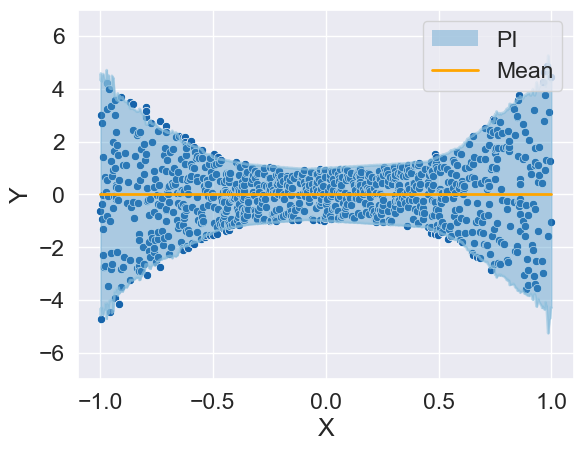

The overall coverage is 0.941
The mean bandwidth for testing data is 4.65365570914206


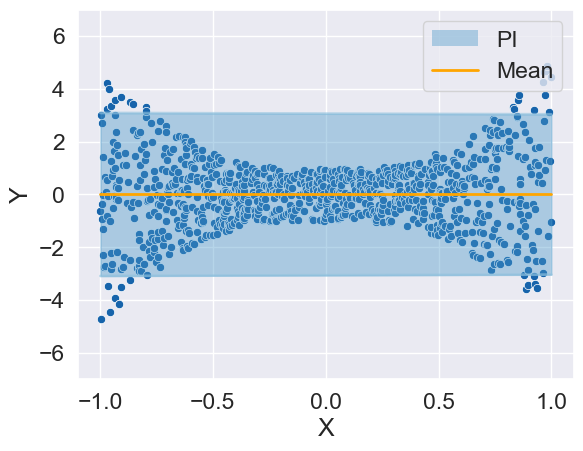

The overall coverage is 0.964
The mean bandwidth for testing data is 9.378609831710905


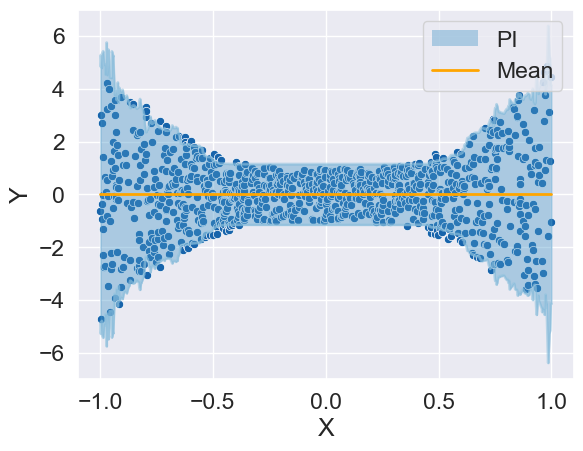

The overall coverage is 0.929
The mean bandwidth for testing data is 4.963575167809934


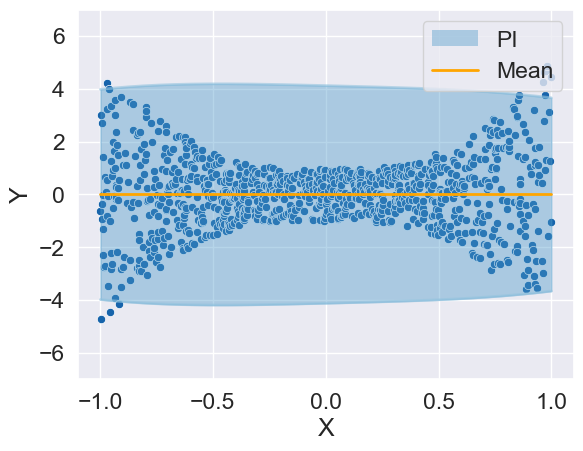

The overall coverage is 0.989
The mean bandwidth for testing data is 16.522572842766714


(0.989, 16.522572842766714)

In [7]:
X,Y = myData(1,n=3000)
UTOPIA(X,Y,n_train=2000,n_t=1000,known_mean ="True")
LQR(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
SplitCF(X,Y,n_train=2000,n_test = 1000,known_mean ="True")
SDP(X,Y,n_train = 2000,n_opt = 100,n_t = 1000,known_mean ="True")